## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso,LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### (a) Obtain Data

Get the Accute Inamations Data Set

In [3]:
acute_inflammations_data="../data/diagnosis.data"
cols=["a1","a2","a3","a4","a5","a6","d1","d2"]
diagnosis_data= pd.read_csv(acute_inflammations_data,encoding='UTF-16',delimiter="\t",names=cols)
diagnosis_data= diagnosis_data.replace(',', '.', regex=True)
diagnosis_data

a1   a2   a3   a4   a5   a6   d1   d2
0    35.5   no  yes   no   no   no   no   no
1    35.9   no   no  yes  yes  yes  yes   no
2    35.9   no  yes   no   no   no   no   no
3    36.0   no   no  yes  yes  yes  yes   no
4    36.0   no  yes   no   no   no   no   no
..    ...  ...  ...  ...  ...  ...  ...  ...
115  41.4   no  yes  yes   no  yes   no  yes
116  41.5   no   no   no   no   no   no   no
117  41.5  yes  yes   no  yes   no   no  yes
118  41.5   no  yes  yes   no  yes   no  yes
119  41.5   no  yes  yes   no  yes   no  yes

[120 rows x 8 columns]

### (b) Build a decision tree

In [4]:
def decision_tree(train, label):
    dtc= tree.DecisionTreeClassifier(criterion='gini', random_state=42)
    dtc.fit(train, label)
    tree.plot_tree(dtc, filled=True)
    return dtc

DecisionTreeClassifier(random_state=42)

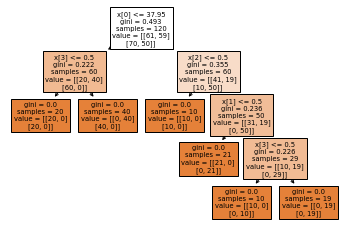

In [5]:
diagnosis_data= diagnosis_data.replace('no', 0, regex=True)
diagnosis_data= diagnosis_data.replace('yes', 1, regex=True)
df=diagnosis_data
X= diagnosis_data.iloc[:, :-2]
Y=diagnosis_data.iloc[:, -2:]

dtc=decision_tree(X,Y)
dtc

In [6]:
tree=dtc
feature_names= df.columns[0:6]

### (c) Convert the decision rules

In [7]:
def tree_to_code(tree, feature_names):
    
    tree_= tree.tree_
    feature_name= [
        feature_names[i] if i !=_tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  "*depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else: # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0,1)
 

In [8]:
tree_to_code(dtc,list(feature_names))

def tree(a1, a2, a3, a4, a5, a6):
  if a1 <= 37.95000076293945:
    if a4 <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else: # if a4 > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else: # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else: # if a3 > 0.5
      if a2 <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else: # if a2 > 0.5
        if a4 <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else: # if a4 > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### (d) Cost complexity pruning

Best ccp alpha: 0.0
def tree(a1, a2, a3, a4, a5, a6):
  if a1 <= 37.95000076293945:
    if a4 <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else: # if a4 > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else: # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else: # if a3 > 0.5
      if a2 <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else: # if a2 > 0.5
        if a4 <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else: # if a4 > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]
Optimal decision tree:


[Text(0.4, 0.9, 'x[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'x[3] <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'x[2] <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'x[1] <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'x[3] <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

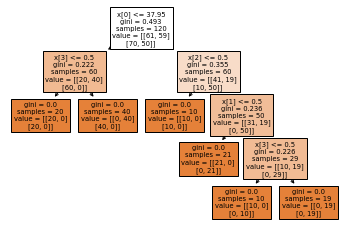

In [9]:
train_x= diagnosis_data.iloc[:, :-2]
train_y=diagnosis_data.iloc[:, -2:]

dtc= DecisionTreeClassifier(random_state=43)
dtc.fit(train_x, train_y)
alphas= dtc.cost_complexity_pruning_path(train_x, train_y)['ccp_alphas']

dtc.fit(train_x, train_y)
dtc= DecisionTreeClassifier(random_state=43)

param_grid= {'ccp_alpha': alphas}
grid_search= GridSearchCV(dtc, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_x, train_y)

best_alpha= grid_search.best_params_['ccp_alpha']

p_dt= DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=43)
p_dt.fit(train_x, train_y)

print("Best ccp alpha:", best_alpha)

tree_to_code(p_dt,list(feature_names))

print("Optimal decision tree:")
plot_tree(p_dt, filled=True)

Rules for minimal decision tree with least depth:
def tree(a1, a2, a3, a4, a5, a6):
  if a1 <= 37.95000076293945:
    return [[20. 40.]
 [60.  0.]]
  else: # if a1 > 37.95000076293945
    return [[41. 19.]
 [10. 50.]]
To find minimal decision tree we plot a tree with least depth:


[Text(0.5, 0.75, 'x[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.25, 0.25, 'gini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.75, 0.25, 'gini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]')]

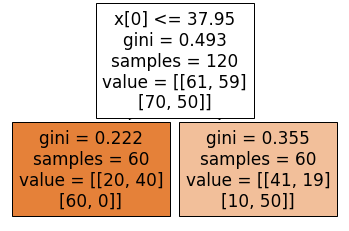

In [10]:
train_x= diagnosis_data.iloc[:, :-2]
train_y=diagnosis_data.iloc[:, -2:]

p_dt_min = DecisionTreeClassifier(max_depth=1)
p_dt_min.fit(train_x, train_y)

print("Rules for minimal decision tree with least depth:")
tree_to_code(p_dt_min,list(feature_names))

print("To find minimal decision tree we plot a tree with least depth:")
plot_tree(p_dt_min, filled=True)


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [11]:
communities_data="../data/communities.data"
communities_cols="../data/communities.names"

c_col=[]

with open(communities_cols,"r") as file:
    for line in file:
        if line.strip().startswith("@attribute"):
            parts= line.split()
            if len(parts) >= 2:
                c=parts[1]
                c_col.append(c)
                
data= pd.read_csv(communities_data, header=None, na_values='?')
data.columns= c_col
data

state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1989     12     NaN        NaN    TempleTerracecity    10        0.01   
1990      6     NaN        NaN          Seasidecity    10        0.05   
1991      9     9.0    80070.0        Waterburytown    10        0.16   
1992     25    17.0    72600.0          Walthamcity    10        0.08   
1993      6     NaN        NaN          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[1994 rows x 128 columns]

In [12]:
def divide_train_test(dataset):
    train_dataset=dataset[:1495]
    test_dataset=dataset[1495:]
    return train_dataset,test_dataset

In [13]:
train_dataset,test_dataset=divide_train_test(data)
train_dataset

state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1490      6     NaN        NaN     Hillsboroughtown     8        0.00   
1491      6     NaN        NaN           Orangecity     8        0.16   
1492     13     NaN        NaN         Waycrosscity     8        0.01   
1493     39    85.0    49056.0           Mentorcity     8        0.06   
1494     34    17.0    79610.0      WestNewYorktown     8        0.05   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1490           0.59          0.01          0.69          1.00  ...      0.02   
1491           0.62          0.03          0.74          0.48  ...      0.07   
1492           0.36          0.95          0.24          0.03  ...      0.03   
1493           0.53          0.01          0.98          0.05  ...      0.08   
1494           0.43          0.08          0.65          0.12  ...      0.00   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1490     0.14            0.22        NaN            NaN                  NaN   
1491     0.40            0.14       0.07           0.05                 0.85   
1492     0.12            0.01        NaN            NaN                  NaN   
1493     0.15            0.02        NaN            NaN                  NaN   
1494     1.00            1.00       0.00           0.01                 0.77   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1490                  NaN                 0.00              NaN   
1491                  0.5                 0.61             0.19   
1492                  NaN                 0.00              NaN   
1493                  NaN                 0.00              NaN   
1494                  0.0                 0.51             0.18   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494                 0.23  

[1495 rows x 128 columns]

In [14]:
test_dataset

state  county  community      communityname  fold  population  \
1495      6     NaN        NaN     MillValleycity     8        0.00   
1496     48     NaN        NaN        LiveOakcity     8        0.00   
1497     35     NaN        NaN       Portalescity     8        0.00   
1498     42    17.0    25112.0      Fallstownship     8        0.04   
1499     51   683.0    48952.0       Manassascity     8        0.03   
...     ...     ...        ...                ...   ...         ...   
1989     12     NaN        NaN  TempleTerracecity    10        0.01   
1990      6     NaN        NaN        Seasidecity    10        0.05   
1991      9     9.0    80070.0      Waterburytown    10        0.16   
1992     25    17.0    72600.0        Walthamcity    10        0.08   
1993      6     NaN        NaN        Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
1495           0.20          0.03          0.91          0.23  ...      0.01   
1496           0.55          0.13          0.78          0.15  ...      0.01   
1497           0.52          0.04          0.59          0.05  ...      0.01   
1498           0.51          0.07          0.92          0.09  ...      0.06   
1499           0.59          0.20          0.75          0.19  ...      0.03   
...             ...           ...           ...           ...  ...       ...   
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
1495     0.23            0.73        NaN            NaN                  NaN   
1496     0.18            0.02        NaN            NaN                  NaN   
1497     0.18            0.00        NaN            NaN                  NaN   
1498     0.13            0.16        NaN            NaN                  NaN   
1499     0.23            0.06        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
1495                  NaN                 0.00              NaN   
1496                  NaN                 0.00              NaN   
1497                  NaN                 0.00              NaN   
1498                  NaN                 0.00              NaN   
1499                  NaN                 0.00              NaN   
...                   ...                  ...              ...   
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
1495                 0.12  
1496                 0.11  
1497                 0.12  
1498                 0.06  
1499                 0.12  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[499 rows x 128 columns]

### (b) Missing values

In [15]:
# Columns state, county,community,communityname and fold are non-predictive
train=train_dataset.drop(columns=["state", "county","community","communityname", "fold"])
test=test_dataset.drop(columns=["state", "county","community","communityname", "fold"])

p_df= pd.concat([train,test], ignore_index=True)
p_df

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20       0.06           0.04   
1         0.02     0.12            0.45        NaN            NaN   
2         0.01     0.21            0.02        NaN            NaN   
3         0.02     0.39            0.28        NaN            NaN   
4         0.04     0.09            0.02        NaN            NaN   
...        ...      ...             ...        ...            ...   
1989      0.01     0.28            0.05        NaN            NaN   
1990      0.02     0.37            0.20        NaN            NaN   
1991      0.08     0.32            0.18       0.08           0.06   
1992      0.03     0.38            0.33       0.02           0.02   
1993      0.11     0.30            0.05       0.08           0.04   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                    0.90                  0.5                 0.32   
1                     NaN                  NaN                 0.00   
2                     NaN                  NaN                 0.00   
3                     NaN                  NaN                 0.00   
4                     NaN                  NaN                 0.00   
...                   ...                  ...                  ...   
1989                  NaN                  NaN                 0.00   
1990                  NaN                  NaN                 0.00   
1991                 0.78                  0.0                 0.91   
1992                 0.79                  0.0                 0.22   
1993                 0.73                  0.5                 1.00   

      PolicBudgPerPop  ViolentCrimesPerPop  
0                0.14                 0.20  
1                 NaN                 0.67  
2                 NaN                 0.43  
3                 NaN                 0.12  
4                 NaN                 0.03  
...               ...                  ...  
1989              NaN                 0.09  
1990              NaN                 0.45  
1991             0.28                 0.23  
1992             0.18   

In [16]:
train_imp = train.fillna(p_df.mean().round(2))
test_imp= test.fillna(p_df.mean().round(2))

imputed_dataset= pd.concat([train_imp,test_imp], ignore_index=True)
imputed_dataset

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20       0.06           0.04   
1         0.02     0.12            0.45       0.16           0.08   
2         0.01     0.21            0.02       0.16           0.08   
3         0.02     0.39            0.28       0.16           0.08   
4         0.04     0.09            0.02       0.16           0.08   
...        ...      ...             ...        ...            ...   
1989      0.01     0.28            0.05       0.16           0.08   
1990      0.02     0.37            0.20       0.16           0.08   
1991      0.08     0.32            0.18       0.08           0.06   
1992      0.03     0.38            0.33       0.02           0.02   
1993      0.11     0.30            0.05       0.08           0.04   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                    0.90                 0.50                 0.32   
1                    0.70                 0.44                 0.00   
2                    0.70                 0.44                 0.00   
3                    0.70                 0.44                 0.00   
4                    0.70                 0.44                 0.00   
...                   ...                  ...                  ...   
1989                 0.70                 0.44                 0.00   
1990                 0.70                 0.44                 0.00   
1991                 0.78                 0.00                 0.91   
1992                 0.79                 0.00                 0.22   
1993                 0.73                 0.50                 1.00   

      PolicBudgPerPop  ViolentCrimesPerPop  
0                0.14                 0.20  
1                0.20                 0.67  
2                0.20                 0.43  
3                0.20                 0.12  
4                0.20                 0.03  
...               ...                  ...  
1989             0.20                 0.09  
1990             0.20                 0.45  
1991             0.28                 0.23  
1992             0.18   

### (c) Plot a correlation matrix

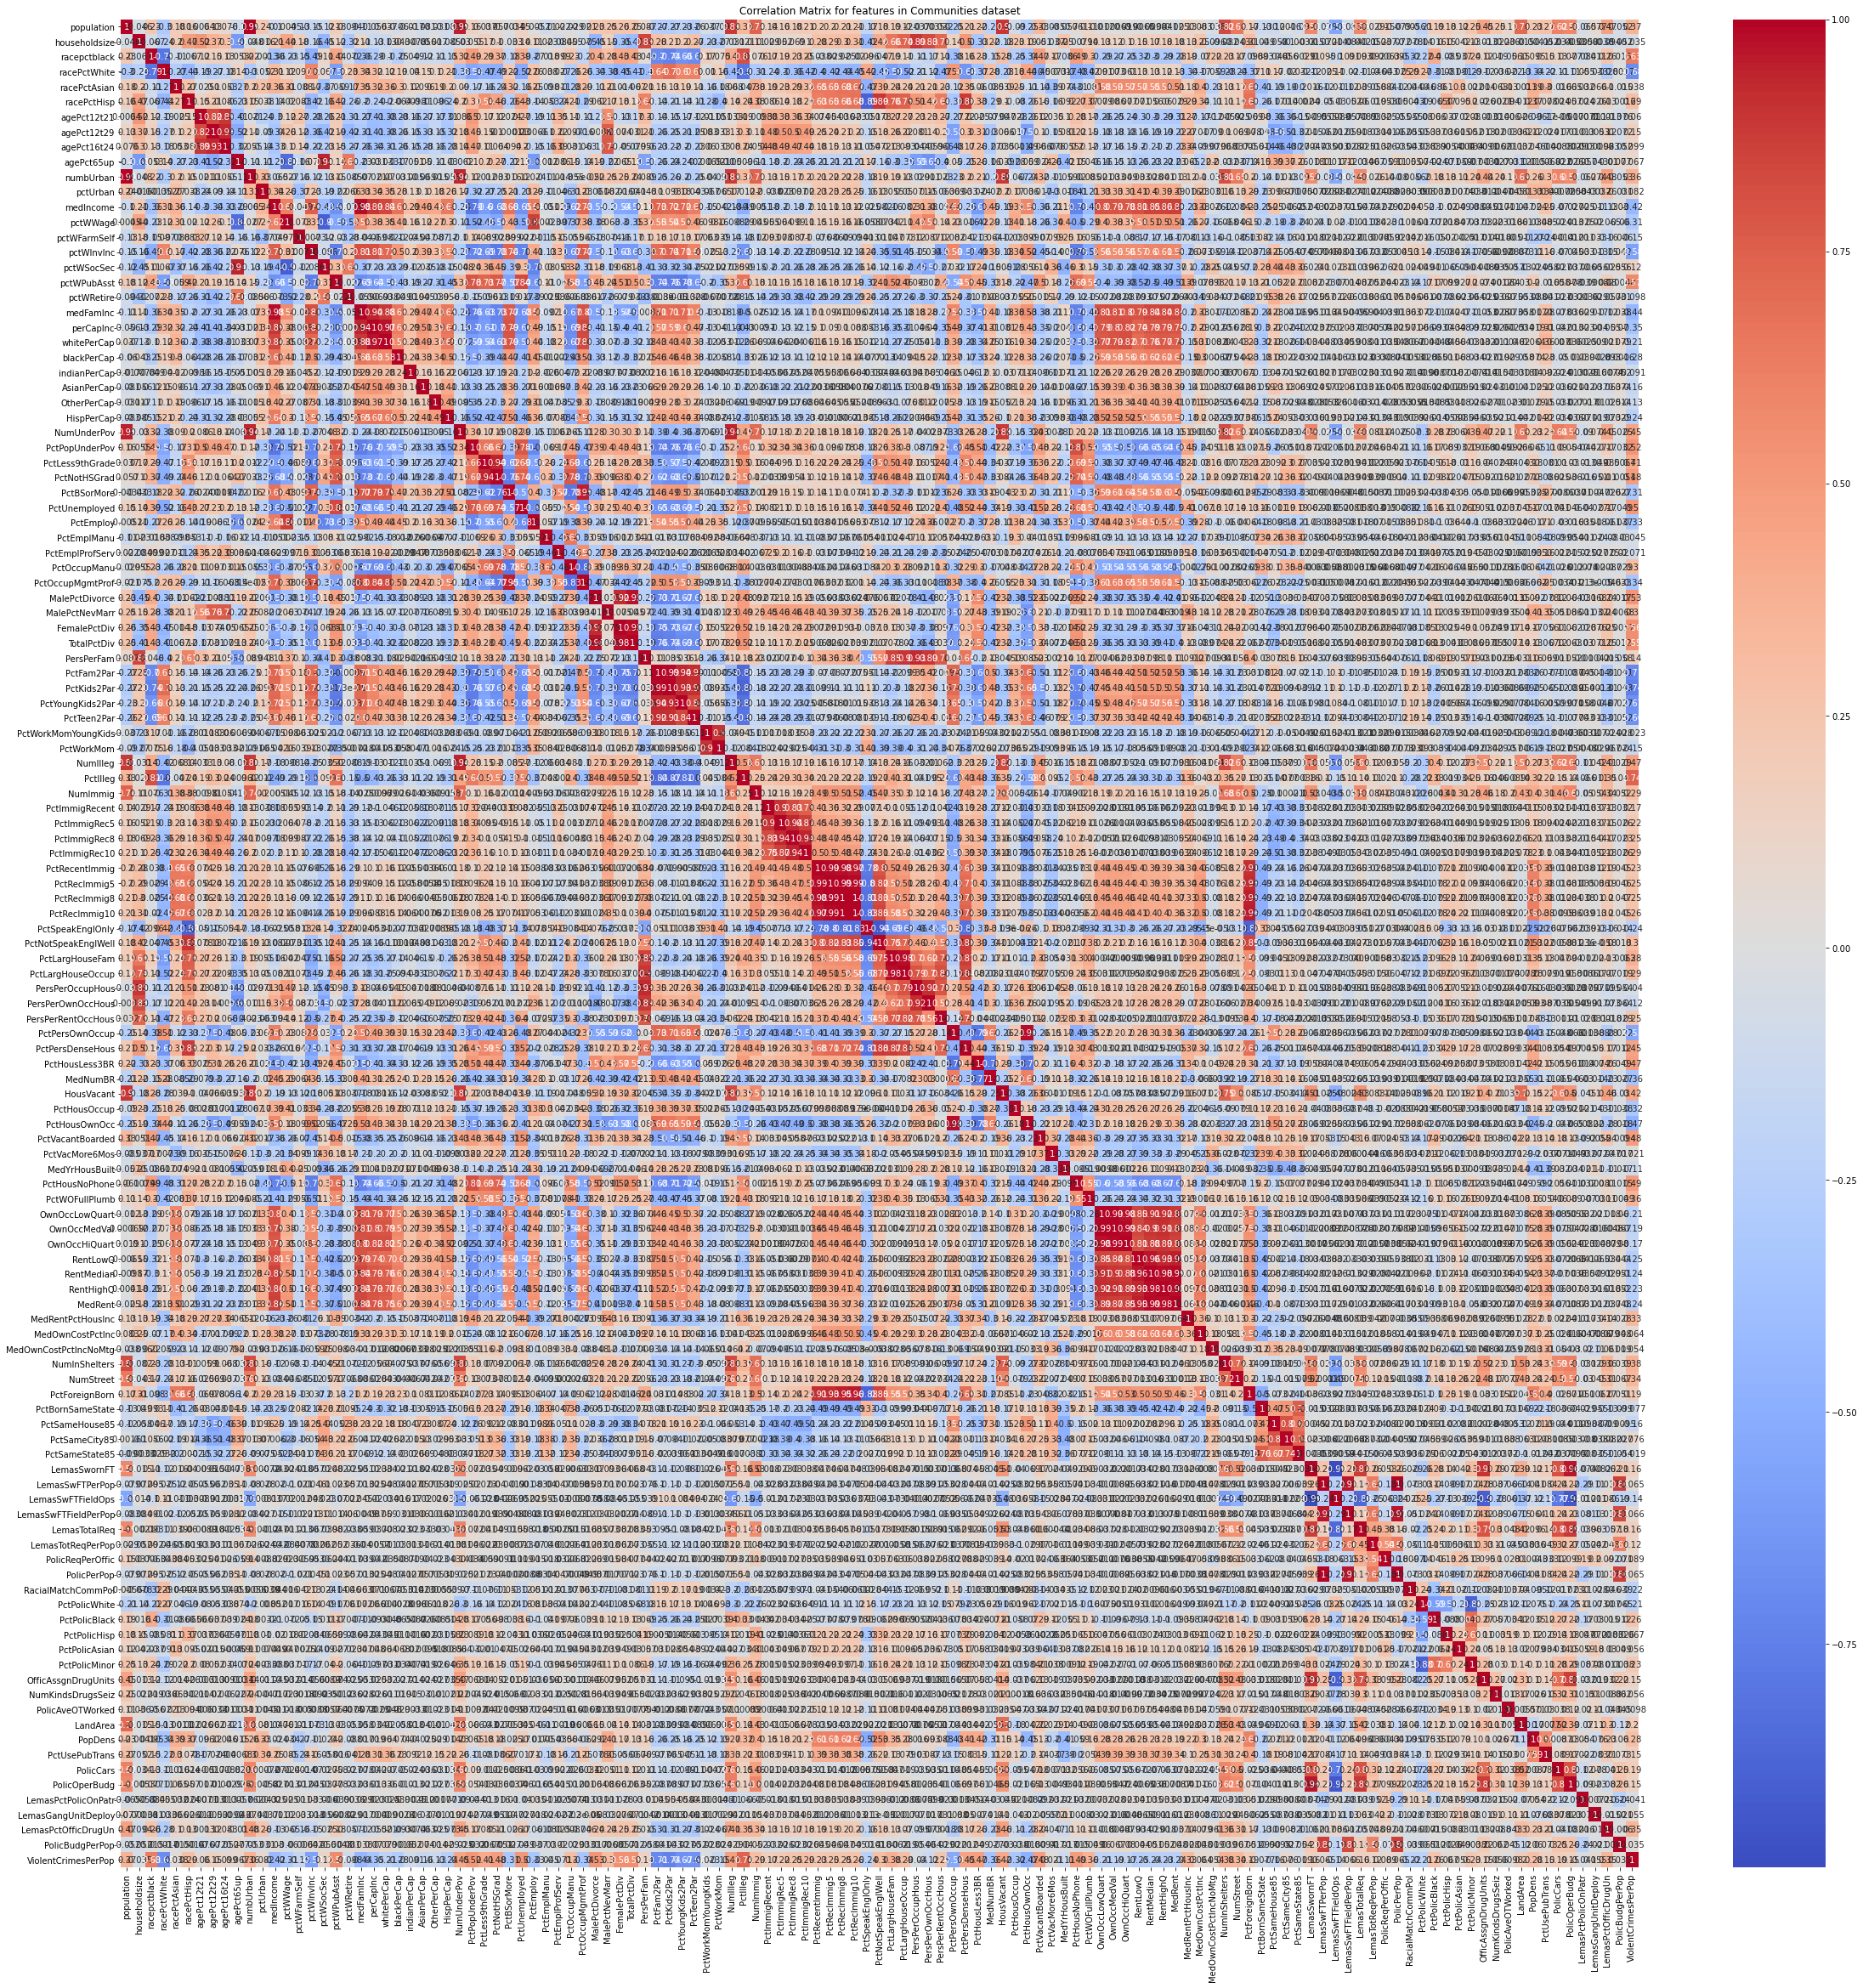

In [17]:
corr= imputed_dataset.corr()

plt.figure(figsize=(40,40))  
sns.heatmap(corr,annot=True,cmap="coolwarm")
plt.title("Correlation Matrix for features in Communities dataset")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [18]:
col= imputed_dataset.columns.tolist()
stats_df= pd.DataFrame()

for column in col:
    std= imputed_dataset[column].std()
    mean= imputed_dataset[column].mean()
    cv=std/mean
    stats_df[column]= [cv]
    
cv=stats_df.T
cv= cv.rename(columns={0:'CV'})
cv

CV
population           2.203503
householdsize        0.353298
racepctblack         1.410920
racePctWhite         0.323782
racePctAsian         1.359162
...                       ...
LemasPctPolicOnPatr  0.122126
LemasGangUnitDeploy  0.368349
LemasPctOfficDrugUn  2.555266
PolicBudgPerPop      0.330405
ViolentCrimesPerPop  0.979015

[123 rows x 1 columns]

### (e) Scatter plots and box plots for highest CV features

In [19]:
n=int((128 ** 0.5)//1)
best_features= cv.sort_values(by='CV',ascending=False)
bf_df=best_features.head(n).T
bf_col=bf_df.columns.tolist()
print(f"{n} Features with highest CV are:")
bf_col

11 Features with highest CV are:


['NumStreet',
 'NumInShelters',
 'NumIlleg',
 'NumImmig',
 'LemasPctOfficDrugUn',
 'NumUnderPov',
 'population',
 'numbUrban',
 'HousVacant',
 'LandArea',
 'racePctHisp']

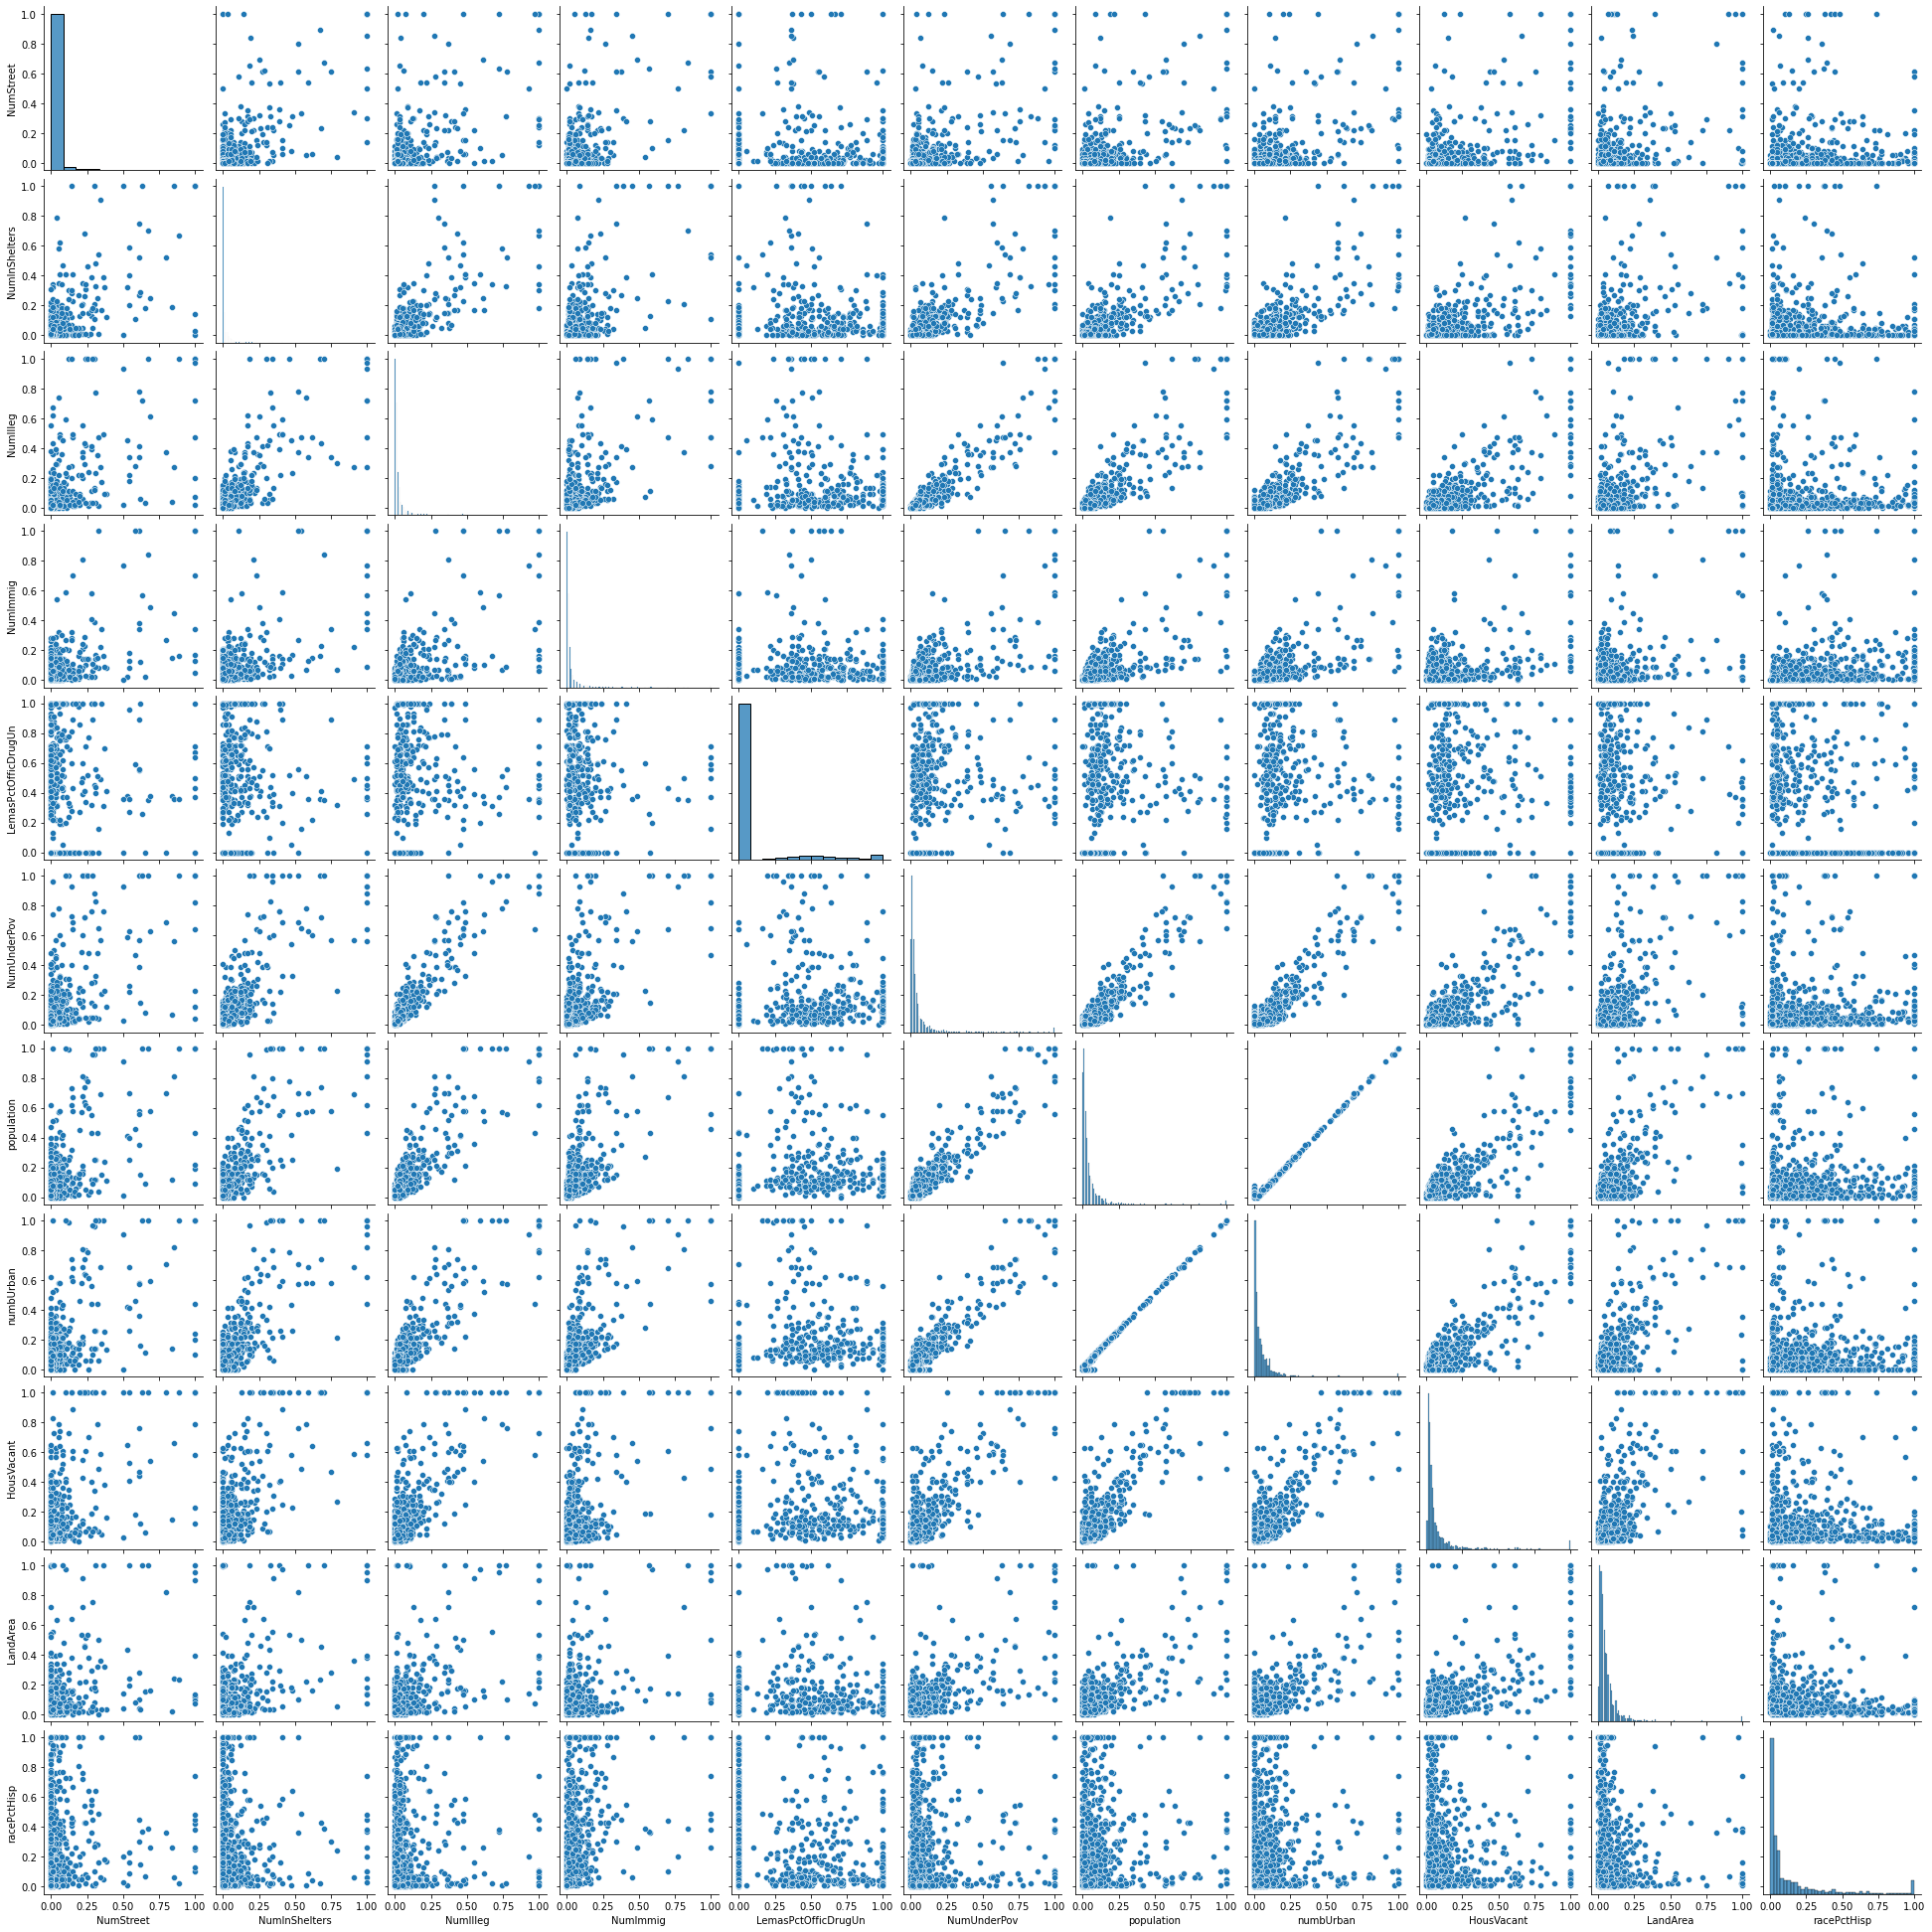

In [20]:
sns.pairplot(imputed_dataset[bf_col])
plt.show()

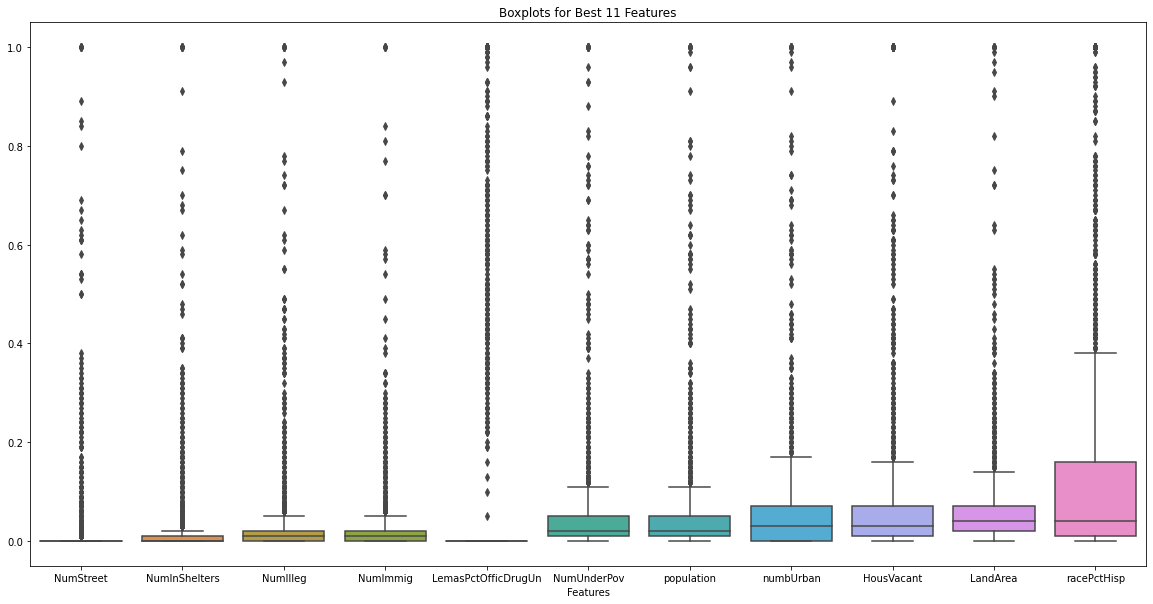

In [21]:
sc=imputed_dataset[bf_col]
plt.figure(figsize=(20,10))
sns.boxplot(data=sc)

plt.xlabel("Features")
plt.title(f"Boxplots for Best {n} Features")
plt.show()

From scatterplot alone, population and numbUrban have linear relationship. From boxplot, we can see that NumStreet and LemasPctOfficDrugUn have highly distributed data.

### (f) Fit a linear model

In [22]:
def divide_x_y(dataset):
    x=dataset.iloc[:,:-1]
    y=dataset.iloc[:,-1]
    return x,y

In [23]:
train1,test1=divide_train_test(imputed_dataset)
train_x,train_y=divide_x_y(train1)
test_x,test_y=divide_x_y(test1)

train_x=sm.add_constant(train_x)
lr_model= sm.OLS(train_y,train_x).fit()
test_x=sm.add_constant(test_x)

pred_te_y= lr_model.predict(test_x)
te_error= mean_squared_error(test_y,pred_te_y)
print("Test error of linear model using least square:",te_error.round(5))


Test error of linear model using least square: 0.01815


### (g) Fit a ridge regression model

In [24]:
train1,test1=divide_train_test(imputed_dataset)
train_x,train_y=divide_x_y(train1)
test_x,test_y=divide_x_y(test1)

choosen_lambda= 0
b_s= float('inf')
lambdas=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]

for l in lambdas:
    r_model= Ridge(alpha=l) 
    scores= cross_val_score(r_model,train_x, train_y, cv=5, scoring='neg_mean_squared_error')
    mean= abs(np.mean(scores))
    
    if mean < b_s:
        b_s= mean
        choosen_lambda= l
        
r_model1= Ridge(alpha=choosen_lambda)
r_model1.fit(train_x,train_y)

y_pred= r_model1.predict(test_x)
te_error= mean_squared_error(test_y,y_pred)

print("Choosen λ by cross validation:",choosen_lambda)
print("Test error of ridge regression:",te_error.round(5))

Choosen λ by cross validation: 1
Test error of ridge regression: 0.01773


### (h) Fit a LASSO model

In [25]:
train1,test1=divide_train_test(imputed_dataset)
train_x,train_y=divide_x_y(train1)
test_x,test_y=divide_x_y(test1)

sv=[]
choosen_lambda= 0
bs= float('inf')
lambdas=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]

for l in lambdas:
    l_model= Lasso(alpha=l) 
    scores= cross_val_score(l_model,train_x,train_y,cv=5,scoring='neg_mean_squared_error') 
    mean= abs(np.mean(scores))
    
    if mean < bs:
        bs= mean
        choosen_lambda= l
print("Choosen λ by cross validation using Lasso model:",choosen_lambda)

l_model= Lasso(alpha=choosen_lambda)
l_model.fit(train_x, train_y)

pred_y= l_model.predict(test_x)
te_error= mean_squared_error(test_y,pred_y)
print("Test error of Lasso Model:",te_error.round(5))

for i in range(len(train_x.columns)):
    if l_model.coef_[i] != 0:
        sv.append(train_x.columns[i])
print("Number of features selected by the model after standardization:", len(sv))        
print("List of variables selected by model after using standardized features:", sv)

Choosen λ by cross validation using Lasso model: 0.0001
Test error of Lasso Model: 0.01778
Number of features selected by the model after standardization: 77
List of variables selected by model after using standardized features: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHo

In [26]:
stand_v=[]

scaler= StandardScaler()
train_x_s= scaler.fit_transform(train_x)
test_x_s= scaler.transform(test_x)

choosen_lambda= 0
bs= float('inf')
lambdas= [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]

for l in lambdas:
    lm= Lasso(alpha=l) 
    scores= cross_val_score(lm, train_x_s,train_y, cv=5, scoring='neg_mean_squared_error') 
    mean= abs(np.mean(scores))
    
    if mean < bs:
        bs= mean
        choosen_lambda= l
        
print("Choosen λ by cross validation using Lasso model after standardization: ",choosen_lambda)

lm_s= Lasso(alpha=choosen_lambda)
lm_s.fit(train_x_s,train_y)

pred_y_s= lm_s.predict(test_x_s)
te_error_s= mean_squared_error(test_y, pred_y_s)

print("Test error of Lasso Model:",te_error_s.round(5))

for i in range(len(train_x.columns)):
    if lm_s.coef_[i] != 0:
        stand_v.append(train_x.columns[i])
        
print("Number of features selected by the model after standardization:", len(stand_v))        
print("List of variables selected by model after using standardized features:", stand_v)

Choosen λ by cross validation using Lasso model after standardization:  0.001
Test error of Lasso Model: 0.01775
Number of features selected by the model after standardization: 67
List of variables selected by model after using standardized features: ['racepctblack', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec5', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctInc

As we can see after standardization number of features selected reduced. Test error is also reduced by very small amount after standardization.

### (i) Fit a PCR model

In [27]:
train1,test1=divide_train_test(imputed_dataset)
train_x,train_y=divide_x_y(train1)
test_x,test_y=divide_x_y(test1)

res= pd.DataFrame(columns=['score', 'index'])
l=len(train_x.columns)
for m in range(1, l+1):
    p_model= PCA(n_components=m)
    l_model= LinearRegression(fit_intercept=True)
    value= cross_val_score(make_pipeline(p_model,l_model),train_x,train_y,cv=KFold(5),scoring="neg_mean_squared_error")
    
    score=round(abs(value.mean()),5)
    res= res.append({'score': score, 'index': m}, ignore_index=True)

min_error= res['score'].min()
c= int(res[res['score'] == min_error]['index'].values[0])

p_model= PCA(n_components=c).fit(train_x)
tr= p_model.transform(train_x)
te= p_model.transform(test_x)
l_model= LinearRegression().fit(tr, train_y)
pred_test_y= l_model.predict(te)
te_error= mean_squared_error(test_y, pred_test_y)

print("Number of principal components:",c)
print("Test error obtained using PCR model: ",te_error.round(5))

Number of principal components: 96
Test error obtained using PCR model:  0.01847


### (j) Fit a boosting tree

In [28]:
train1,test1=divide_train_test(imputed_dataset)
train_x,train_y=divide_x_y(train1)
test_x, test_y=divide_x_y(test1)

choosen_alpha= 0
bs= float('inf')
alphas=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]

for a in alphas:
    x_model= xgb.XGBRegressor(objective='reg:squarederror',reg_alpha=a)
    scores= cross_val_score(x_model, train_x,train_y, cv=5, scoring='neg_mean_squared_error') 
    mean= abs(np.mean(scores))
    
    if mean < bs:
        bs= mean
        choosen_alpha= a
print("α (the regularization term) using cross-validation:",choosen_alpha)

α (the regularization term) using cross-validation: 1


In [29]:
x_model= xgb.XGBRegressor(objective='reg:squarederror',reg_alpha = choosen_alpha)
x_model.fit(train_x,train_y)

pred_y= x_model.predict(test_x)
te_error= mean_squared_error(test_y, pred_y)
print("Test error using XGBoost:",te_error)

Test error using XGBoost: 0.017824939270829766


References:
1. https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
2. https://www.statology.org/principal-components-regression-in-python/